# Importing Libraries

In [1]:
import json
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as TrainTestSplit
from Preprocessing.DataLoaders.CyLertDataLoaders import TimeLabeledDataLoader
from Preprocessing.DataHandler import DataHandler
from Classifiers.CyLertClassifiers import PrimitiveClassifier

Some weights of BertModel were not initialized from the model checkpoint at markusbayer/CySecBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Initializng Data Handler

In [2]:
DataHandler = DataHandler()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Initializing Primitive Classifier

In [3]:
InputDim = 768
LabelsCount = 5
ConnectedLayersCount = 1

In [4]:
Classifier = keras.Sequential()
Classifier = PrimitiveClassifier(InputDim = InputDim, NeuronsLayersCount = [100], OutputDim = LabelsCount, ConnectedLayersCount = ConnectedLayersCount).Classifier

In [5]:
Classifier.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["f1_score", "accuracy"])

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Loading Required Data

In [6]:
ReadFileToken = "r"

In [7]:
ServersNames = ["cup", "insect", "onion", "spiral"]

EventsAlertsDatasetDirectoryPathList = [f"../Datasets/AIT-LDS V1.1/data/mail.{ServerName}.com/suricata/" for ServerName in ServersNames]

LabelsDirectoryPathList = [f"../Datasets/AIT-LDS V1.1/labels/mail.{ServerName}.com/suricata/" for ServerName in ServersNames]

In [8]:
EventAlertDataset = []

for EventsAlertsDatasetDirectoryPath in EventsAlertsDatasetDirectoryPathList:

	with open (EventsAlertsDatasetDirectoryPath + "eve.json", ReadFileToken) as EventAlertDatasetFile:

		while(True):

			Line = EventAlertDatasetFile.readline()

			if not Line:

				break

			EventAlertDataset.append(Line)


In [9]:
Labels = []

for LabelsDirectoryPath in LabelsDirectoryPathList:

	with open (LabelsDirectoryPath + "eve.json", ReadFileToken) as LabelsPath:

		while(True):

			Line = LabelsPath.readline()

			if not Line:

				break
			
			Labels.append(Line.split(",")[0])

			

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Data Sampling

In [10]:
LabelsFrequency = {}

for Index, Label in enumerate(Labels):

	GroupLabel = "webshell" if "webshell" in Label else Label
	
	LabelsFrequency[GroupLabel] = (LabelsFrequency.get(GroupLabel, 0) + 1)

In [11]:
DesiredRecordsCount = 2000

DesiredLabelsFrequency = {}

for Label, Frequency in LabelsFrequency.items():

	if Frequency > 500:

		DesiredLabelsFrequency[Label] = min(DesiredRecordsCount, Frequency)


In [12]:
Dataset = list(zip(EventAlertDataset, Labels))
random.shuffle(Dataset)

In [13]:
FilteredDataset = []

KnownLabels = {"0" : 0}

LastKnownLabelId = 1

for EventAlert, Label in (Dataset):

	GroupLabel = "webshell" if "webshell" in Label else Label

	if (GroupLabel not in KnownLabels) and (GroupLabel in DesiredLabelsFrequency):

		KnownLabels[GroupLabel] = LastKnownLabelId

		FilteredDataset.append \
		(
			(
				EventAlert,
				[1 if flag == LastKnownLabelId else 0 for flag in range(len(DesiredLabelsFrequency))],
			)
		)

		LastKnownLabelId += 1

	elif (GroupLabel in KnownLabels) and (DesiredLabelsFrequency[GroupLabel] > 0):

		FilteredDataset.append \
		(
			(
				EventAlert,
				[1 if flag == KnownLabels[GroupLabel] else 0 for flag in range(len(DesiredLabelsFrequency))],
			)
		)

	else:

		continue

	DesiredLabelsFrequency[GroupLabel] = DesiredLabelsFrequency[GroupLabel] - 1

In [14]:
Dataset = pd.DataFrame(FilteredDataset, columns = ["Event/Alert", "Label"])

In [15]:
del EventAlertDataset, Labels

In [16]:
TestDataSize = 0.2
ValidationDataSize = 0.25
TrainingDataSize = 1 - TestDataSize - ValidationDataSize 

In [17]:
XTrainingData, XTestingValidationData, YTrainingData, YTestingValidationData = \
TrainTestSplit \
(
	Dataset[Dataset.columns[:len(Dataset.columns) - 1]],
	Dataset[Dataset.columns[len(Dataset.columns) - 1]],
	test_size = TrainingDataSize
)

In [18]:
XValidationData, YTestingData, YValidationData, YTestingData = \
TrainTestSplit \
(
	XTestingValidationData,
	YTestingValidationData,
	test_size = ValidationDataSize / (1 - TrainingDataSize)
)

In [19]:
del Dataset

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Training Model

In [20]:
def GenerateBatches(*, DataHandler, XData, YData, BatchSize = 128):

	XTrainingBatch = []
	YTrainingBatch = []

	for column in XData:

		for RecordIndex, Record in enumerate(XData[column]):

			XTrainingBatch.append(DataHandler.EncodeData(DataHandler.FormatData(json.loads(Record))).detach().numpy()[0])

			YTrainingBatch.append(YData.iloc[[RecordIndex]].values[0])

			if (RecordIndex + 1) % BatchSize == 0:
				
				yield np.array(XTrainingBatch, dtype = float), np.array(YTrainingBatch, dtype = float)

				XTrainingBatch = []
				YTrainingBatch = []

			if (RecordIndex == len(XData[column])):

				yield np.array(XTrainingBatch, dtype = float), np.array(YTrainingBatch, dtype = float)


In [21]:
Epochs = 20

TrainingHistoryList = []

ValidationHistoryList = []

for _ in range(Epochs):

	TrainingHistoryList.append \
	(
		Classifier.fit \
		(
			GenerateBatches(DataHandler = DataHandler, XData = XTrainingData, YData = YTrainingData, BatchSize = 128),
			epochs = 1,
			verbose = True
		)
	)

	ValidationHistoryList.append(Classifier.evaluate(GenerateBatches(DataHandler = DataHandler, XData = XValidationData, YData = YValidationData, BatchSize = 128)))

33/33 ━━━━━━━━━━━━━━━━━━━━ 3999s 125s/step - accuracy: 0.3742 - f1_score: 0.3057 - loss: 1.5205


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2037s 120s/step - accuracy: 0.4674 - f1_score: 0.3676 - loss: 1.2777
33/33 ━━━━━━━━━━━━━━━━━━━━ 3939s 123s/step - accuracy: 0.5305 - f1_score: 0.4534 - loss: 1.2217
18/18 ━━━━━━━━━━━━━━━━━━━━ 2050s 121s/step - accuracy: 0.5507 - f1_score: 0.4735 - loss: 1.1275
33/33 ━━━━━━━━━━━━━━━━━━━━ 3952s 123s/step - accuracy: 0.5673 - f1_score: 0.4918 - loss: 1.1072
18/18 ━━━━━━━━━━━━━━━━━━━━ 2048s 120s/step - accuracy: 0.5650 - f1_score: 0.4927 - loss: 1.0835
33/33 ━━━━━━━━━━━━━━━━━━━━ 3941s 123s/step - accuracy: 0.5813 - f1_score: 0.5129 - loss: 1.0671
18/18 ━━━━━━━━━━━━━━━━━━━━ 2048s 120s/step - accuracy: 0.5849 - f1_score: 0.5428 - loss: 1.0586
33/33 ━━━━━━━━━━━━━━━━━━━━ 3972s 124s/step - accuracy: 0.5930 - f1_score: 0.5347 - loss: 1.0394
18/18 ━━━━━━━━━━━━━━━━━━━━ 2072s 122s/step - accuracy: 0.6009 - f1_score: 0.5721 - loss: 1.0302
33/33 ━━━━━━━━━━━━━━━━━━━━ 3956s 124s/step - accuracy: 0.5991 - f1_score: 0.5485 - loss: 1.0143
18/18 ━━━━━━━━━━━━━━━━━━━━ 2052s 121s/st

In [84]:
TrainingLossPerEpoch = [History.history["loss"] for History in TrainingHistoryList]
TrainingAccuracyPerEpoch = [History.history["accuracy"] for History in TrainingHistoryList]
TrainingF1ScorePerEpoch = [History.history["f1_score"] for History in TrainingHistoryList]

In [85]:
ValidationLossPerEpoch = [EvaluationResults[0] for EvaluationResults in ValidationHistoryList]
ValidationF1ScorePerEpoch = [EvaluationResults[1] for EvaluationResults in ValidationHistoryList]
ValidationAccuracyPerEpoch = [EvaluationResults[2] for EvaluationResults in ValidationHistoryList]

In [86]:
BenignF1ScoreResults = [float(TrainingF1ScoreResults[0][0]) for TrainingF1ScoreResults in  TrainingF1ScorePerEpoch]
HydraF1ScoreResults = [float(TrainingF1ScoreResults[0][1]) for TrainingF1ScoreResults in  TrainingF1ScorePerEpoch]
NiktoF1ScoreResults = [float(TrainingF1ScoreResults[0][2]) for TrainingF1ScoreResults in  TrainingF1ScorePerEpoch]
VrfyF1ScoreResults = [float(TrainingF1ScoreResults[0][3]) for TrainingF1ScoreResults in  TrainingF1ScorePerEpoch]
WebshellF1ScoreResults = [float(TrainingF1ScoreResults[0][4]) for TrainingF1ScoreResults in  TrainingF1ScorePerEpoch]

In [87]:
EpochsAxis = [i + 1 for i in range(Epochs)]

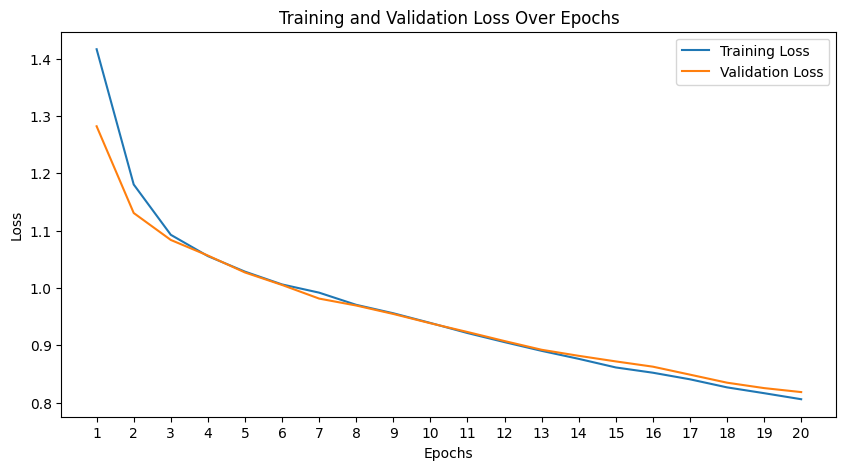

In [88]:
plt.figure(figsize = (10, 5))
plt.plot(EpochsAxis, TrainingLossPerEpoch, label = 'Training Loss')
plt.plot(EpochsAxis, ValidationLossPerEpoch, label = 'Validation Loss')
plt.xticks(EpochsAxis)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

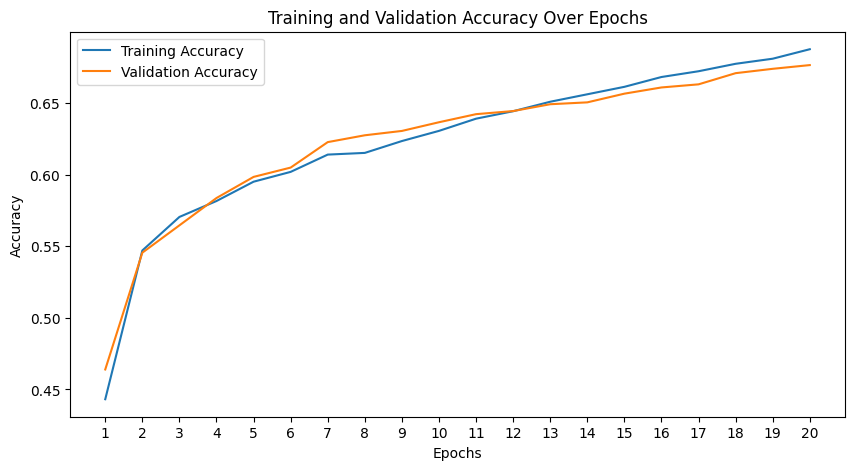

In [89]:
plt.figure(figsize = (10, 5))
plt.plot(EpochsAxis, TrainingAccuracyPerEpoch, label = 'Training Accuracy')
plt.plot(EpochsAxis, ValidationAccuracyPerEpoch, label = 'Validation Accuracy')
plt.xticks(EpochsAxis)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

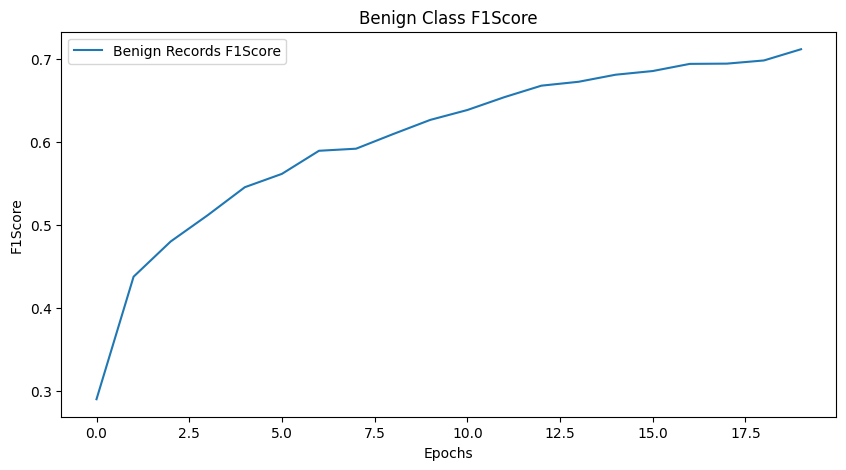

In [90]:

plt.figure(figsize = (10, 5))
plt.plot(BenignF1ScoreResults, label = 'Benign Records F1Score')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.title('Benign Class F1Score')
plt.legend()
plt.show()


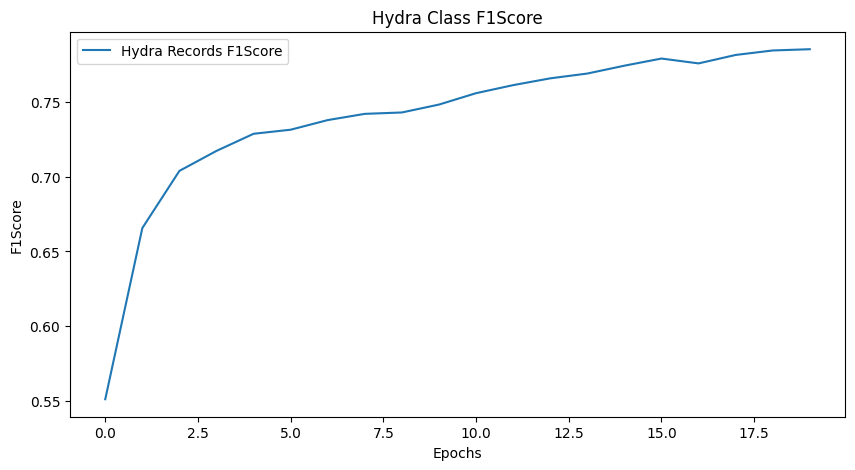

In [91]:

plt.figure(figsize = (10, 5))
plt.plot(HydraF1ScoreResults, label = 'Hydra Records F1Score')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.title('Hydra Class F1Score')
plt.legend()
plt.show()


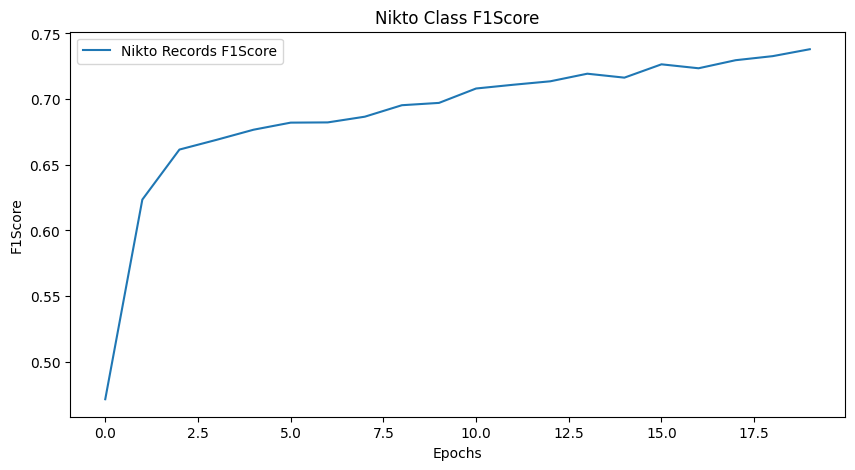

In [92]:
plt.figure(figsize = (10, 5))
plt.plot(NiktoF1ScoreResults, label = 'Nikto Records F1Score')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.title('Nikto Class F1Score')
plt.legend()
plt.show()

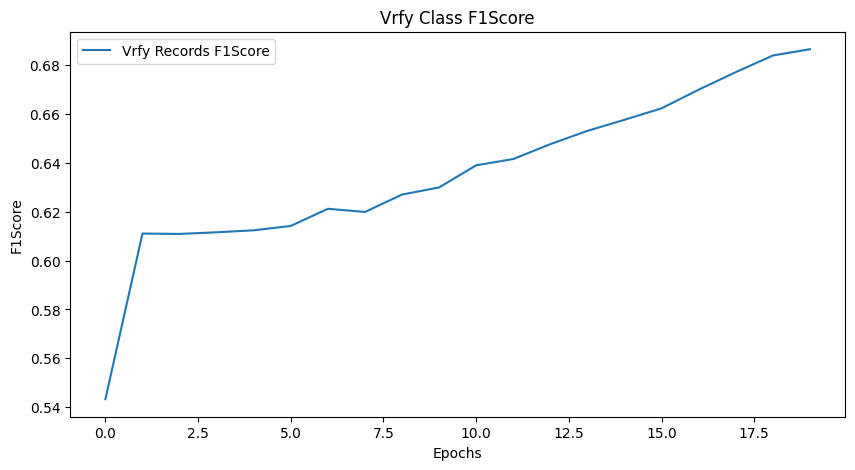

In [93]:
plt.figure(figsize = (10, 5))
plt.plot(VrfyF1ScoreResults, label = 'Vrfy Records F1Score')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.title('Vrfy Class F1Score')
plt.legend()
plt.show()

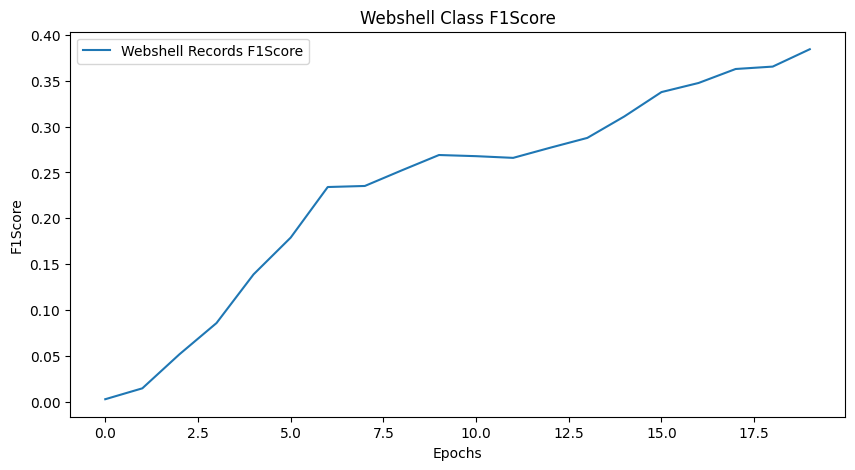

In [94]:
plt.figure(figsize = (10, 5))
plt.plot(WebshellF1ScoreResults, label = 'Webshell Records F1Score')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.title('Webshell Class F1Score')
plt.legend()
plt.show()